In [2]:
from IPython.display import Image

## summary

- LoRA: **Lo**w-**R**ank **A**daption of large language models
    - A random projection to a smaller subspace
    - parameter efficient
        - PEFT 
    - https://arxiv.org/abs/2106.09685
- 实现细节上
    - 是一个 adaptor of pretrained model
        - adaptor 是小的
        - pretrained model 是大的
            - large language models
            - large vision models
    - **freezes** pre-trained model weights
    - **injects** trainable rank decomposition matrices
        - into each layer of transformer Architecture

- 基本思想
    - 对于 transformer，最为重要的 self attention module
        - Wq、Wk、Wv、Wo 表示 learnable query/key/value/output projection matrices 
        - 将这些记为模型的参数 $\Phi$
    - 在 full fine-tune （不进行任何的 freeze）时，model 会初始化为预训练好的权重 $\Phi$，最终 fine-tune 之后，调整为 $\Phi+\Delta\Phi$（基于反向传播和梯度下降）
        - 每一个下游任务都要学习对应的 $\Delta\Phi$（$|\Delta\Phi|=|\Phi|$）
    - LoRA 作为一个 parameter efficient 将与（进一步）下游任务相关的 $\Delta\Phi=\Delta\Phi(\Theta)$，进一步编码（encode）为规模更小的参数 $\Theta$
        - $|\Theta| \ll |\Delta\Phi|=|\Phi|$
        - LoRA 采用 low-rank representation 来 encode $\Delta\Phi$

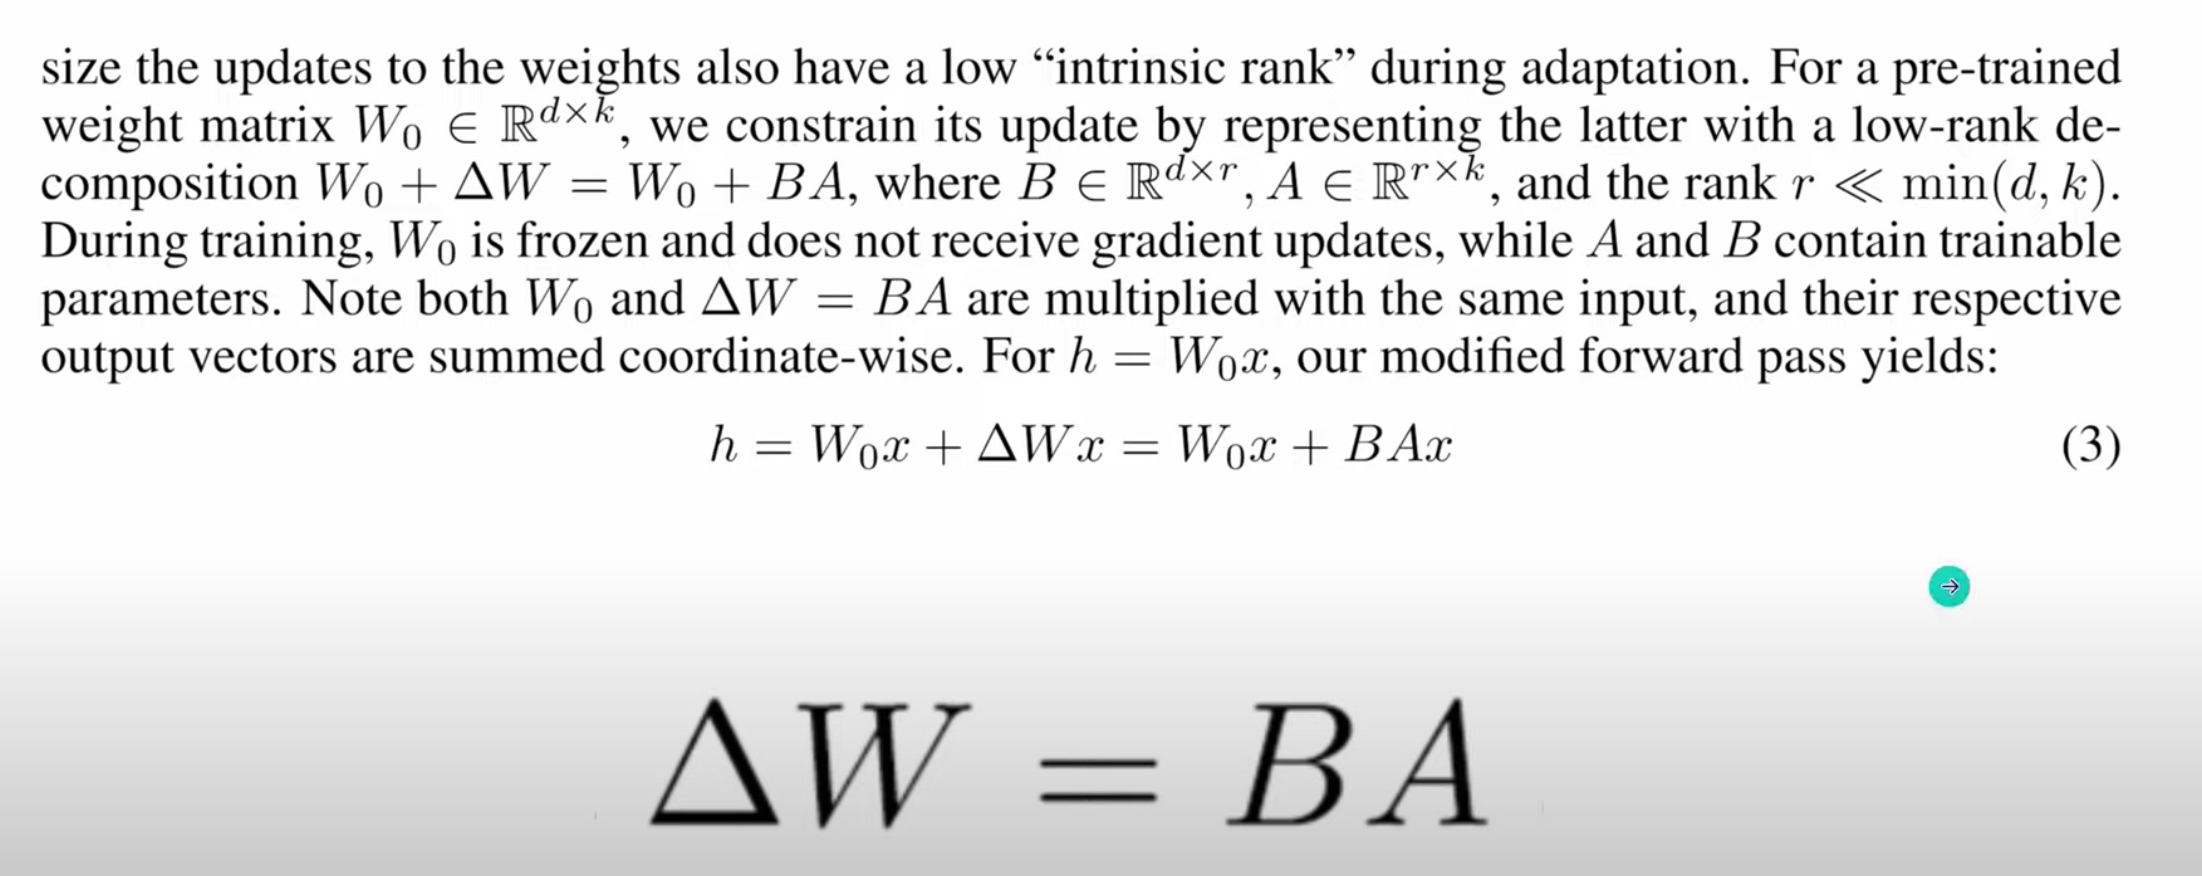

In [5]:
# https://arxiv.org/abs/2106.09685
Image('../imgs/lora.png', width=600)

## ft vs. lora


$$
\begin{split}
&h=f_W(x)\\
&\Downarrow\\
&h=f_{W+\Delta W}(x)\\
\end{split}
$$

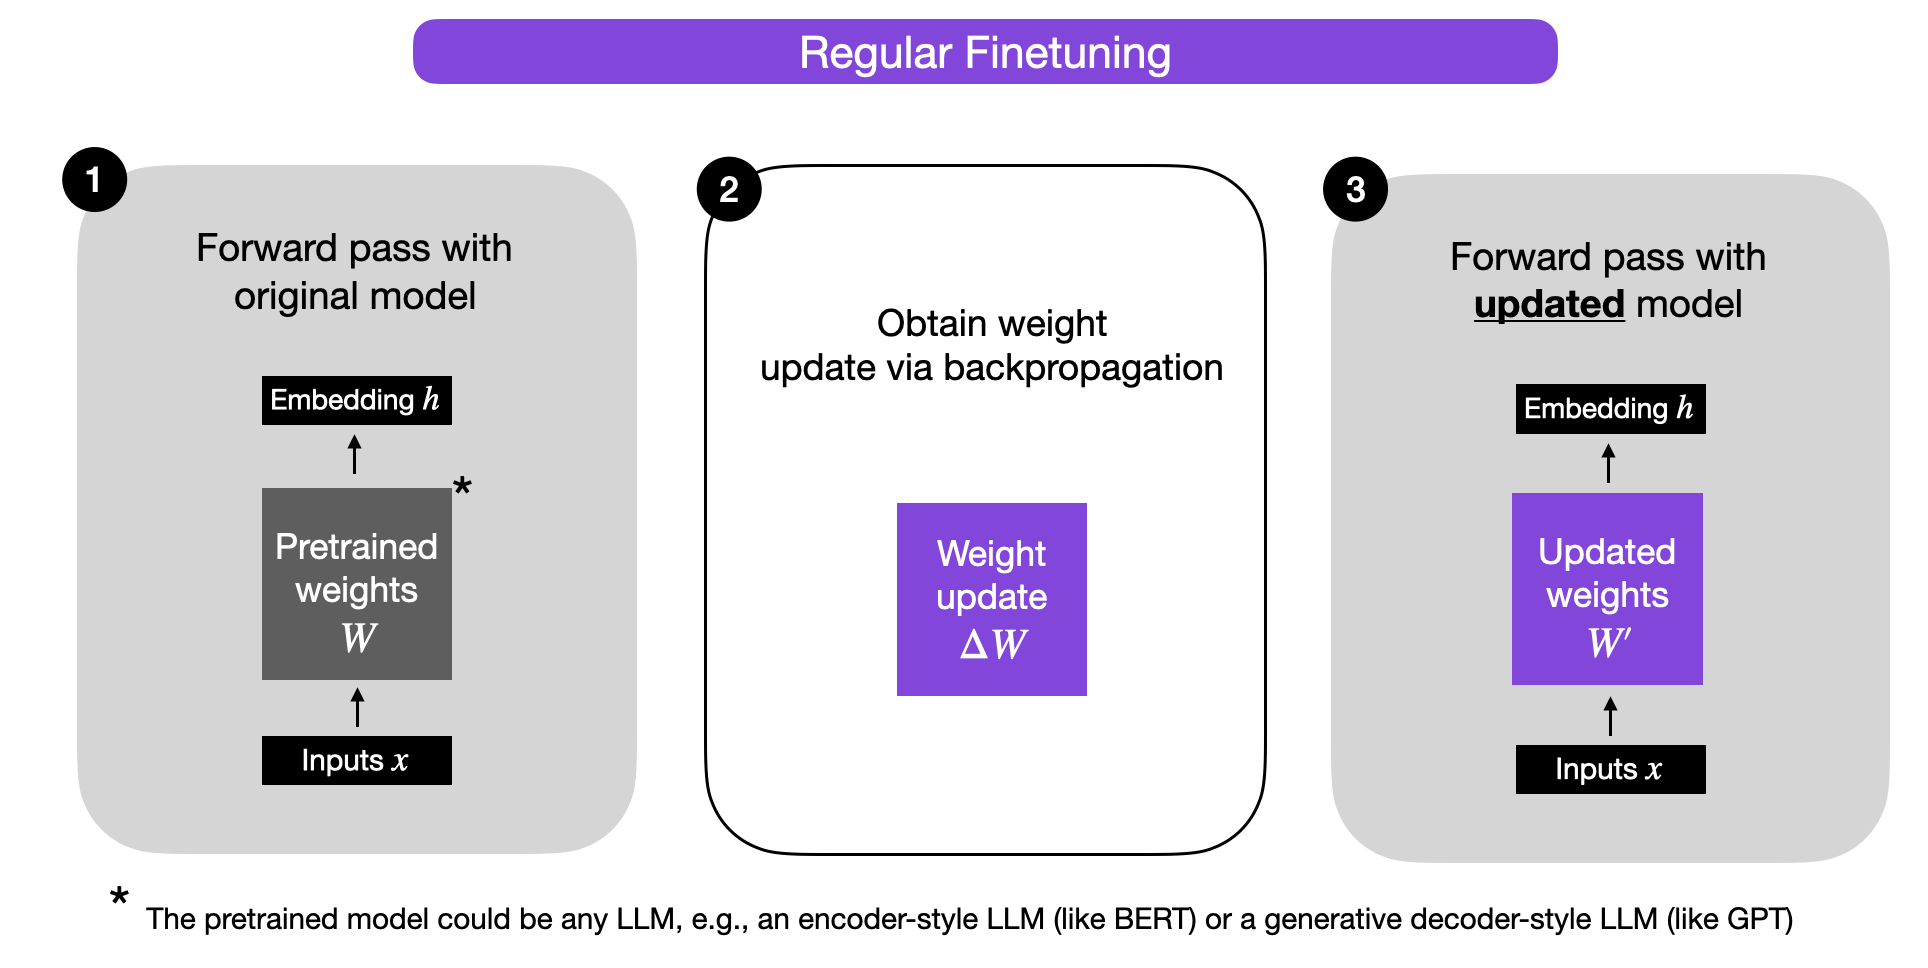

In [35]:
Image('../imgs/regular-finetuning.png', width=600)

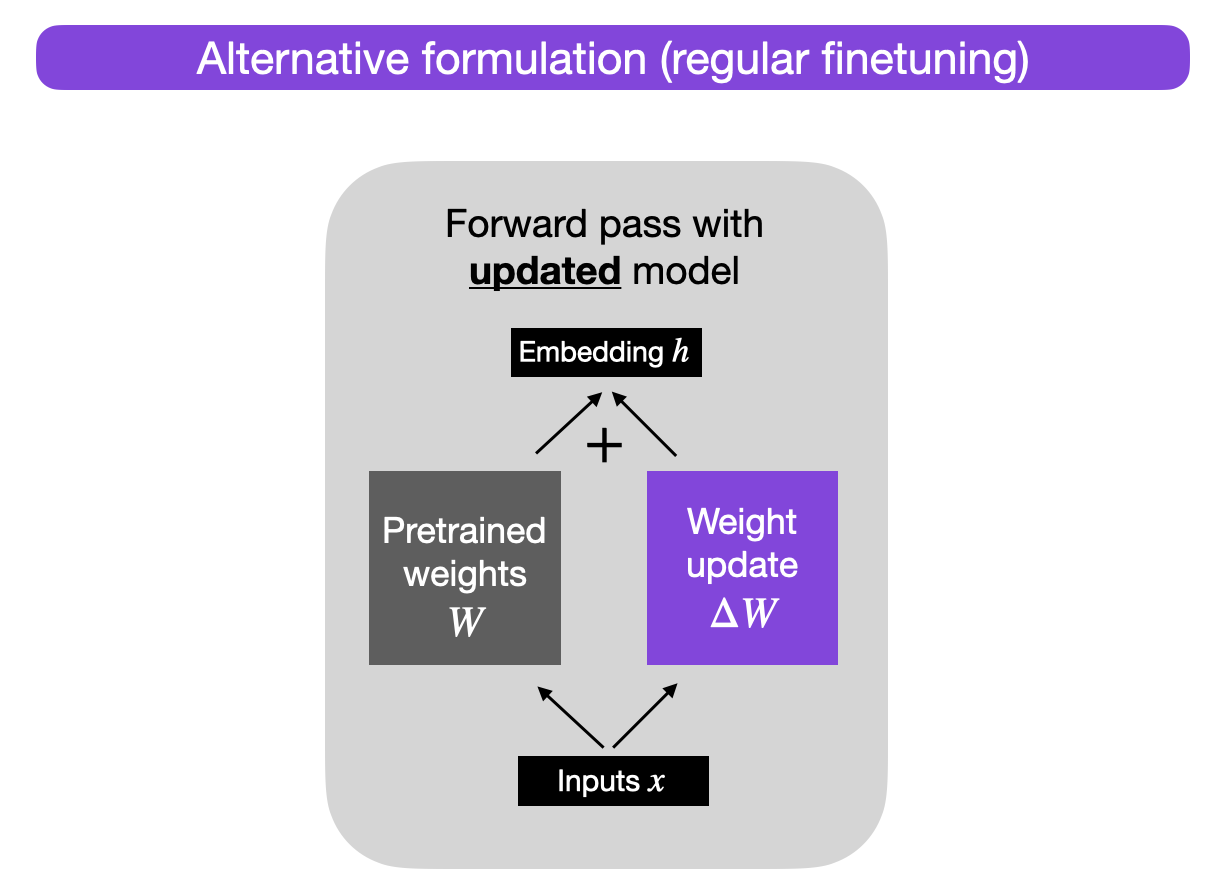

In [37]:
Image('../imgs/regular-finetuning-alt.png', width=500)


- $W\in\mathbb R^{A\times B}$

$$
\Delta W=W_AW_B,\\
W_A\in \mathbb R^{A\times r}, W_B\in \mathbb R^{r\times B}
$$

- 最终的参数量由 $A\times B $ 降至 $r\times (A+B)$
    - A=100，B=500，r=5
    - 5\*(100+500) / (100\*500) == 3000/50000 == 6%
    - 这就叫 Parameter efficiency 


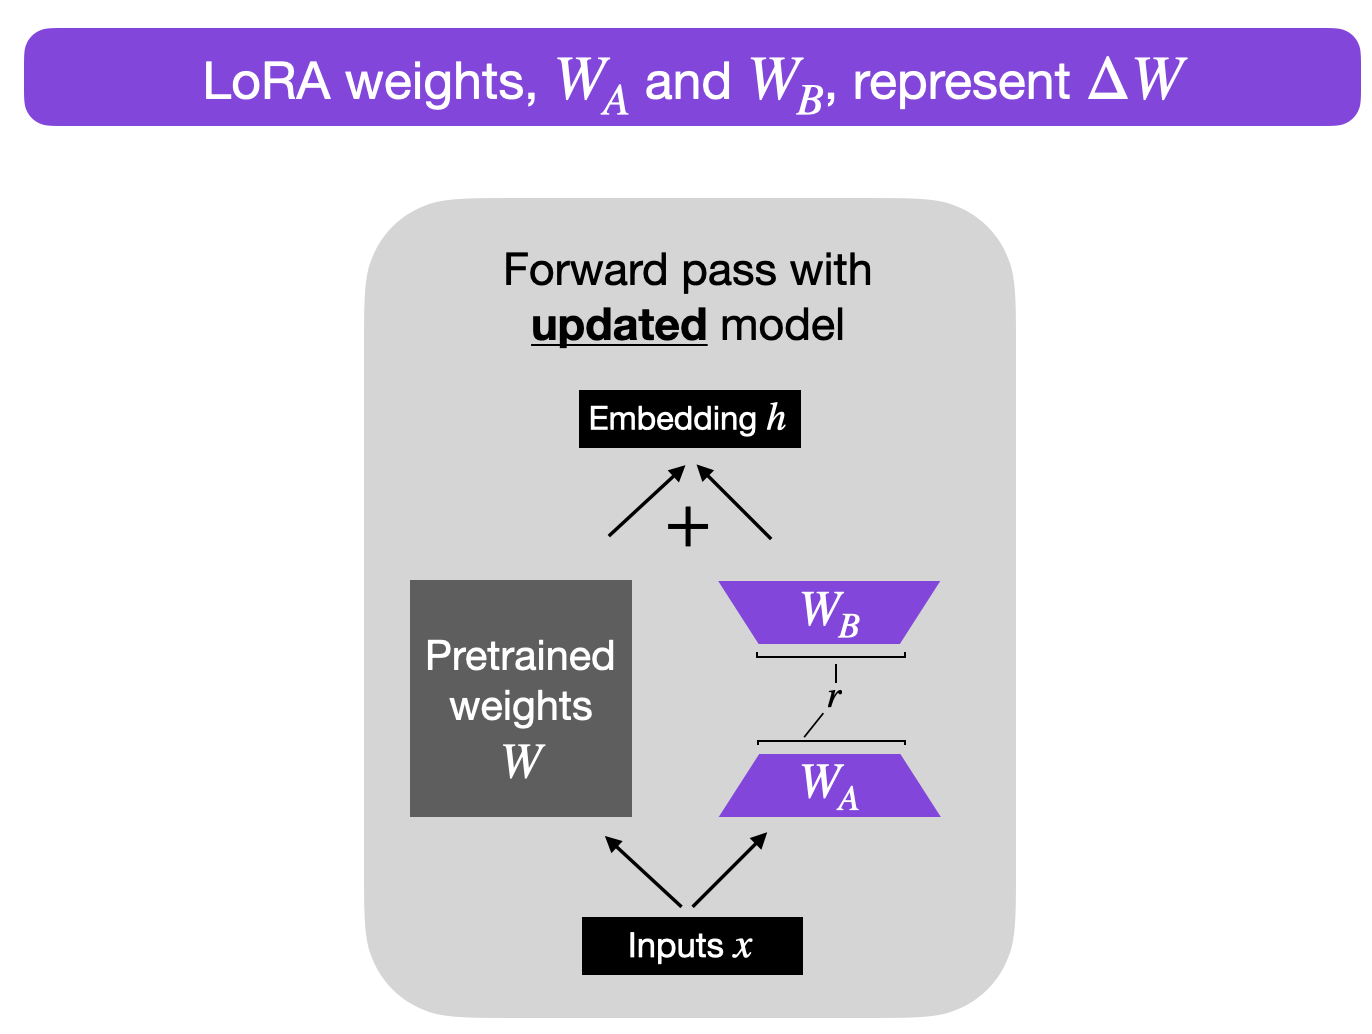

In [39]:
Image('../imgs/lora-weights.png', width=600)

## 伪代码

- $r$ 会是一个超参: a trade-off between model complexity, adaptation capacity, and the risk of underfitting or overfitting
    - A smaller $r$ leads to a simpler low-rank matrix, which results in fewer parameters to learn during adaptation. 
        -  This can lead to faster training and potentially reduced computational requirements. 
    - However, with a smaller $r$, the capacity of the low-rank matrix to capture task-specific information decreases.
        - This may result in lower adaptation quality, and the model might not perform as well on the new task compared to a higher $r$.


```
input_dim = 768  # e.g., the hidden size of the pre-trained model
output_dim = 768  # e.g., the output size of the layer
rank = 8  # The rank 'r' for the low-rank adaptation

W = ... # from pretrained network with shape input_dim x output_dim

W_A = nn.Parameter(torch.empty(input_dim, rank)) # LoRA weight A
W_B = nn.Parameter(torch.empty(rank, output_dim)) # LoRA weight B

# Initialization of LoRA weights
nn.init.kaiming_uniform_(W_A, a=math.sqrt(5))
nn.init.zeros_(W_B)

def regular_forward_matmul(x, W):
    h = x @ W
return h

def lora_forward_matmul(x, W, W_A, W_B):
    h = x @ W  # regular matrix multiplication
    h += x @ (W_A @ W_B) * alpha # use scaled LoRA weights
return h
```

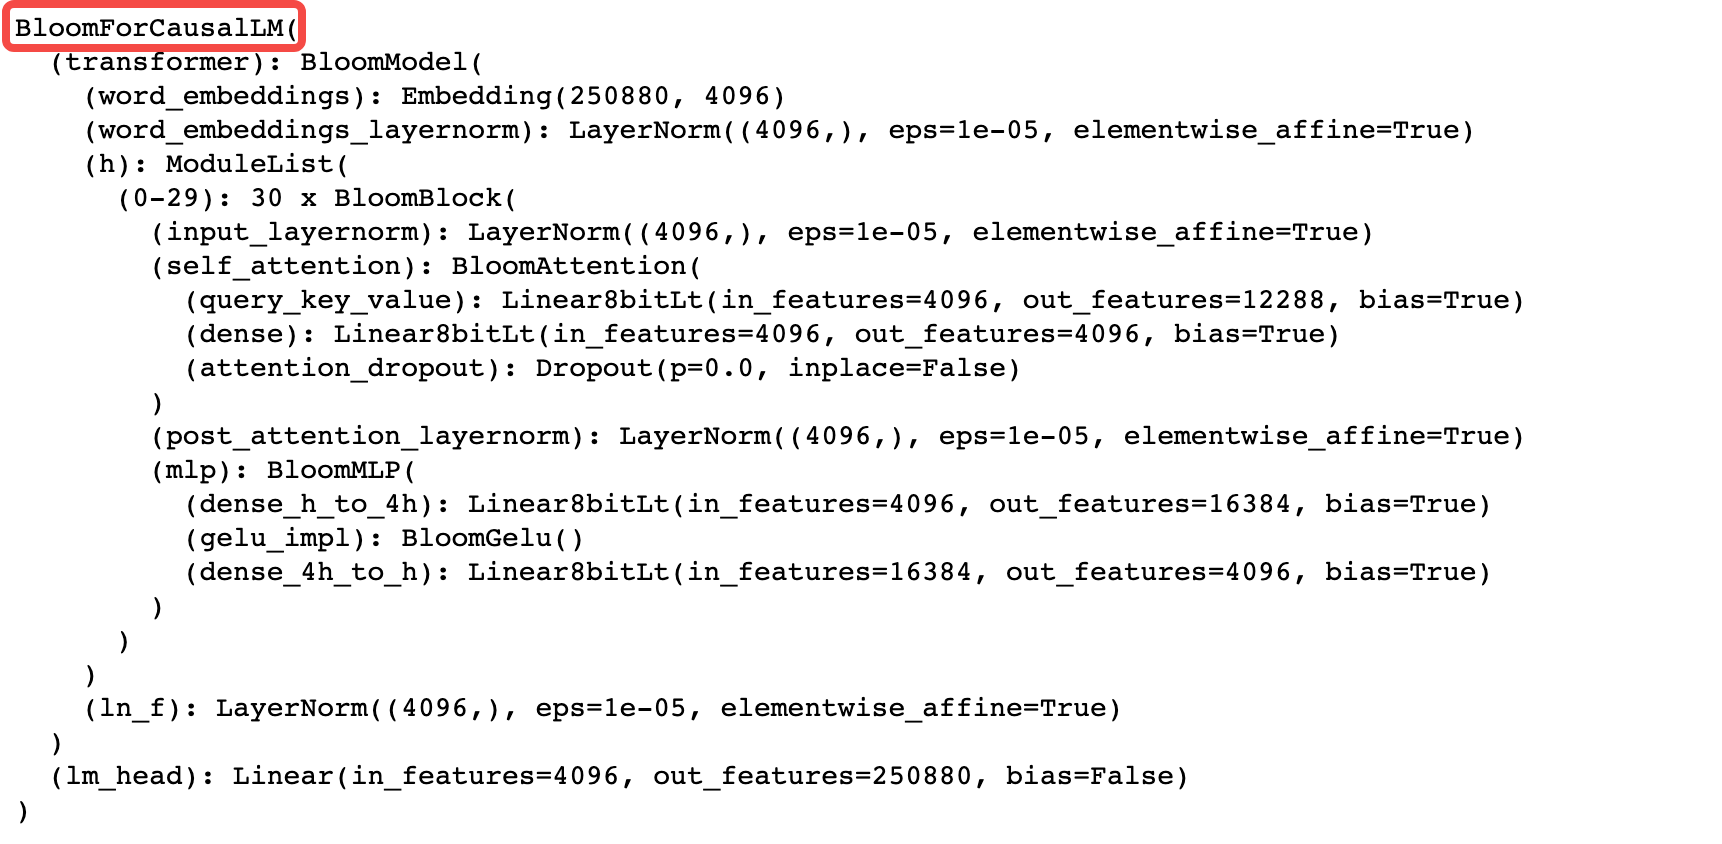

In [3]:
Image('../imgs/bloom.png')

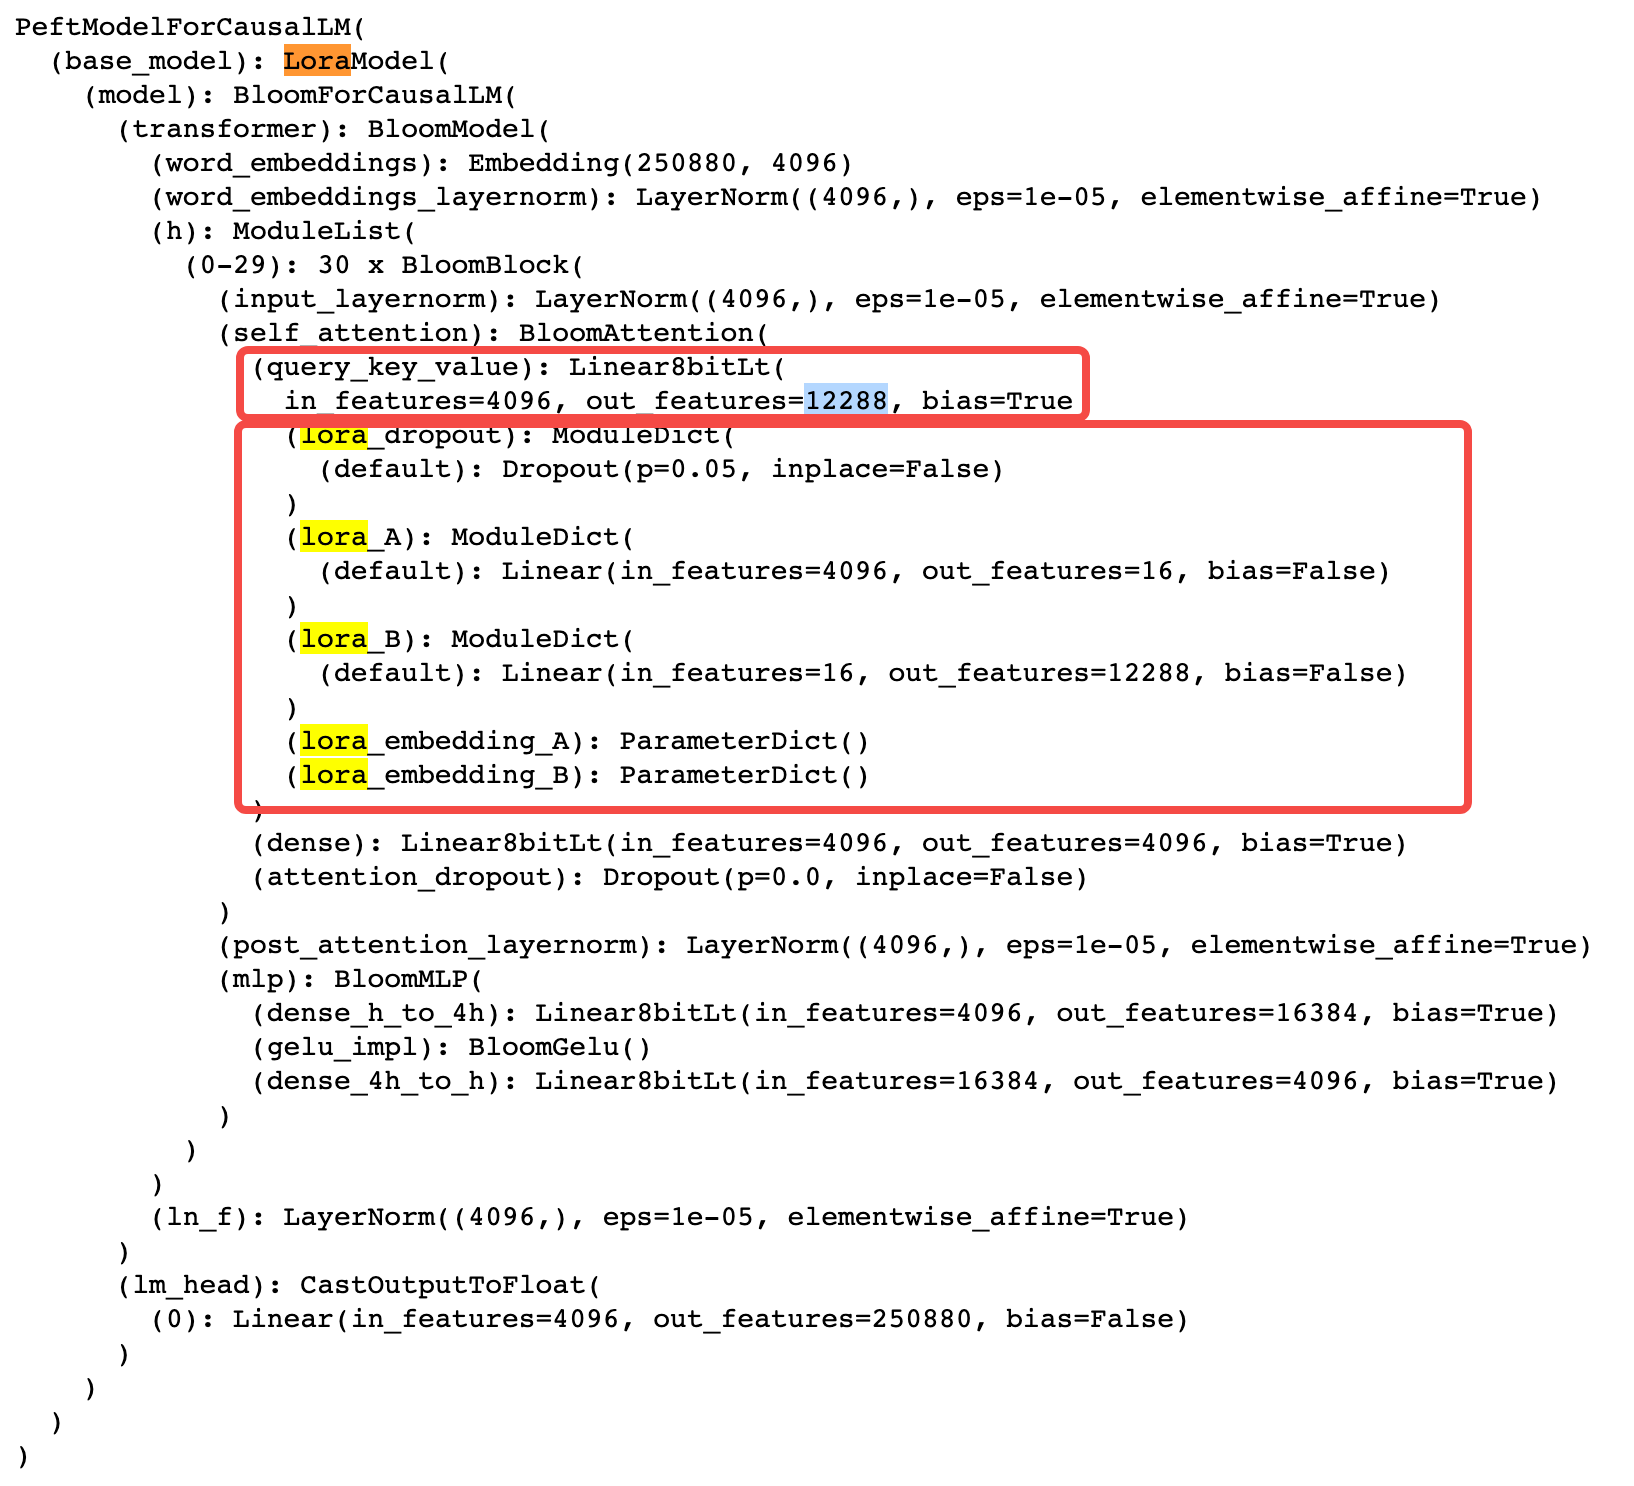

In [4]:
Image('../imgs/bloom_lora.png')